In [1]:
import numpy as np 
import torch

import datasets.mnist as mnist
import datasets.cifar10 as cifar10
import constants
from configuration import Configuration

from util import *

In [2]:
# on the cblgpu01 or 06 computer
checkpoints_methods = [
    #('run-20210520_201621-1tac73ie', 'Ens 3'), ('run-20210520_232903-3edza10c', 'MCDrop 3, rate 0.1'), 
    #('run-20210520_215226-2829ms12', 'NCEns 3 anneal'), ('run-20210520_183333-q4byxnks', 'NCEns 3 w2'), 
    ('run-20210521_002758-6tow019f', 'Single'), ('run-20210521_133234-2zgcfz21', 'Ens 5'),
    #('run-20210521_135148-2174fa8f', 'NCEns 5 anneal'), 
    ('run-20210521_135356-1z9btw0n', 'NCEns 5 w2'),
    ('run-20210521_135447-18fwsxyd', 'MCDrop 5, rate 0.1')
    ]

checkpoints_annealing = [
    #('run-20210523_202732-2o5htajn', 'NCEns-5 w10 decay0.985'),
    #('run-20210524_054053-k9s2cx2i', 'NCEns-5 w5'),
    ('run-20210523_224635-2m4ul8lw', 'NCEns-5 w10 decay0.98'),
    ('run-20210524_010345-9gt6gv8b', 'NCEns-5 w100 decay0.93'),
    #('run-20210524_032114-b14iu9ek', 'NCEns-5 w100 decay0.9')
]

In [3]:
checkpoints = checkpoints_methods + checkpoints_annealing

In [4]:
device='cuda'
checkpoint_epoch = 180


In [5]:
# for CIFAR, shifted ID data
corruption_intensity = 4
thresholds = np.linspace(0, 1, 50)
entropy_bins = np.linspace(-1, 2.5, 100)

res = []

for run_id, name in checkpoints:

    checkpointed_args = f'/scratch/gp491/wandb/checkpoints/{run_id}/args.json'
    checkpointed_model = f'/scratch/gp491/wandb/checkpoints/{run_id}/epoch_{checkpoint_epoch}.pth'

    model_args = Configuration.from_json(checkpointed_args)
    trainer = get_trainer(model_args, device=device)
    trainer.load_checkpoint(checkpointed_model)

    test_loader = cifar10.get_test_loader(model_args.data_dir, model_args.batch_size, corrupted=True, corruptions=constants.CORRUPTIONS, intensities=[corruption_intensity])


    metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                    'ECE': metrics.wrap_ece(bins=20), 
                    'Brier': metrics.wrap_brier()}

    acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies = trainer.test(test_loader=test_loader, metric_dict=metric_dict, confidence_thresholds=thresholds, entropy_bins=entropy_bins)

    res.append((name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies))

SGD optimizer
using multistep scheduler
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1485/1485 [00:14<00:00, 99.53batch/s]
Results: 
Accuracy: 0.6187684210526316
NLL: 2.391129793448197
ECE: 0.28229436558586984
Brier: 0.6290117104680915
Initialising an ensemble of 5 networks
SGD optimizer
  0%|          | 0/1485 [00:00<?, ?batch/s]
Testing
  0%|          | 5/1485 [00:00<01:19, 18.56batch/s]/homes/gp491/deepens/metrics.py:230: UserWa

In [6]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Count vs Confidence. Corrupted, intensity 4')

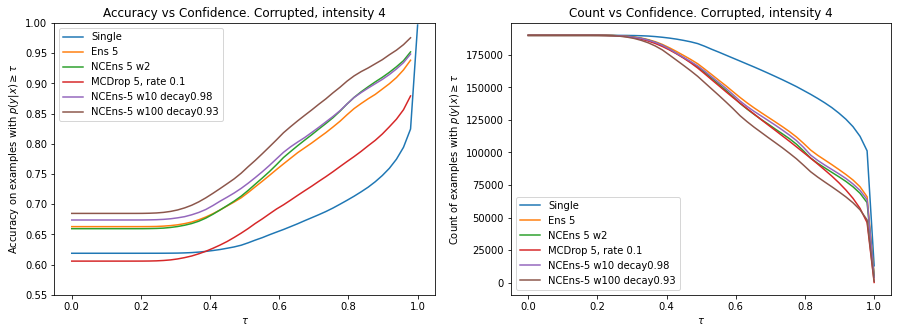

In [7]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(thresholds, thresholded_accuracies, label=name)
# plt.plot(thresholds, thresholds, '--')
plt.ylim(0.55, 1)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Accuracy on examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Accuracy vs Confidence. Corrupted, intensity {corruption_intensity}')

plt.subplot(122)
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(thresholds, thresholded_counts, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Count of examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Count vs Confidence. Corrupted, intensity {corruption_intensity}')

Single
78220.0
Ens 5
50334.0
NCEns 5 w2
47008.0
MCDrop 5, rate 0.1
25881.0
NCEns-5 w10 decay0.98
49137.0
NCEns-5 w100 decay0.93
32844.0


Text(0.5, 1.0, 'Count vs Entropy. Corrupted, intensity 4')

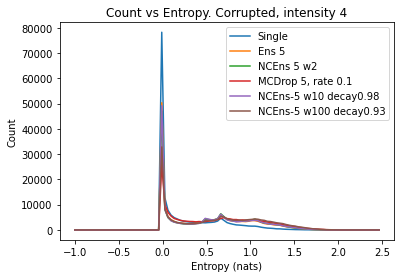

In [8]:
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res:
    plt.plot(entropy_bins[:-1], binned_entropies, label=name)
    print(name)
    print(max(binned_entropies))
plt.xlabel(r'Entropy (nats)')
plt.ylabel(r'Count')
plt.legend()
plt.title(f'Count vs Entropy. Corrupted, intensity {corruption_intensity}')

## OOD Data

In [9]:
import torchvision

In [10]:
# for CIFAR
thresholds = np.linspace(0, 1, 50)
entropy_bins = np.linspace(-1, 2.5, 100) # since only entropy really makes sense

res_ood = []

for run_id, name in checkpoints:

    checkpointed_args = f'/scratch/gp491/wandb/checkpoints/{run_id}/args.json'
    checkpointed_model = f'/scratch/gp491/wandb/checkpoints/{run_id}/epoch_{checkpoint_epoch}.pth'

    model_args = Configuration.from_json(checkpointed_args)
    trainer = get_trainer(model_args, device=device)
    trainer.load_checkpoint(checkpointed_model)

    test_set = torchvision.datasets.SVHN(root=constants.DATA_DIR, split='train', download=True, transform=torchvision.transforms.ToTensor())
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)


    metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                    'ECE': metrics.wrap_ece(bins=20), 
                    'Brier': metrics.wrap_brier()}

    acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies = trainer.test(test_loader=test_loader, metric_dict=metric_dict, confidence_thresholds=thresholds, entropy_bins=entropy_bins)

    res_ood.append((name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies))

SGD optimizer
using multistep scheduler
Using downloaded and verified file: /scratch/gp491/data/train_32x32.mat
  0%|          | 0/573 [00:00<?, ?batch/s]/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/proj-env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/homes/gp491/deepens/metrics.py:230: UserWarning: Warning: converting a masked element to nan.
  accuracies[i] = np.ma.masked_array(eq, mask=~mask).mean(-1)
  1%|          | 5/573 [00:00<00:12, 45.60batch/s]
Testing
100%|██████████| 573/573 [00:10<00:00, 54.50batch/s]
Results: 
Accuracy: 0.12342847782464

Single
6103.0
Ens 5
4060.0
NCEns 5 w2
7061.0
MCDrop 5, rate 0.1
3124.0
NCEns-5 w10 decay0.98
11743.0
NCEns-5 w100 decay0.93
3377.0


Text(0.5, 1.0, 'Count vs Entropy. OOD dataset.')

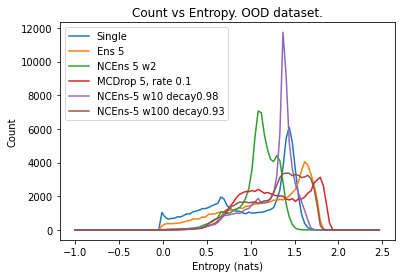

In [11]:
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(entropy_bins[:-1], binned_entropies, label=name)
    print(name)
    print(max(binned_entropies))
plt.xlabel(r'Entropy (nats)')
plt.ylabel(r'Count')
plt.legend()
plt.title(f'Count vs Entropy. OOD dataset.')

Text(0.5, 1.0, 'Count vs Confidence. OOD Data')

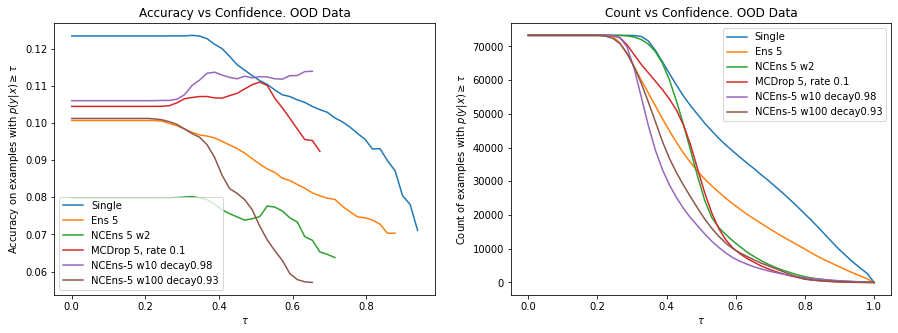

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(121)

for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(thresholds, thresholded_accuracies, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Accuracy on examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Accuracy vs Confidence. OOD Data')

plt.subplot(122)
for name, acc, metric_res, thresholded_accuracies, thresholded_counts, binned_entropies in res_ood:
    plt.plot(thresholds, thresholded_counts, label=name)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Count of examples with $p(y|x) \geq \tau$')
plt.legend()
plt.title(f'Count vs Confidence. OOD Data')

In [ ]:
print(res_ood[0][3])